In [3]:
import dask
dask.config.set({"dataframe.query-planning": False})

import numpy as np
import pandas as pd
import sys
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gseapy as gp
import PyComplexHeatmap as pch
from PyComplexHeatmap import HeatmapAnnotation, DotClustermapPlotter, anno_simple, anno_label
from scipy.stats import zscore
from tqdm import tqdm
from pathlib import Path

sys.path.append("../../../workflow/scripts/")
import _utils
import readwrite
cfg = readwrite.config()
sns.set_style('ticks')


def get_top_n_genes(group,n=20,value_vars=None,agg_func='mean',ascending=False):
    '''Sort each row by descending value, keep top n '''

    if value_vars is None:
        value_vars = group.columns

    if len(group) == 1:
        top = group.iloc[0][value_vars].dropna()
    else:
        if agg_func=='mean':
            top = group[value_vars].mean()
        elif agg_func=='median':
            top = group[value_vars].median()
        else:
            raise ValueError('unrecognized agg_func')

    if ascending:
        top_genes = top.nsmallest(n).index.tolist()
    else:
        top_genes = top.nlargest(n).index.tolist()
    
    return top_genes


def winsorize_asymmetric(data, neg_q=0.01, pos_q=0.99, return_data=False):
    data = np.asarray(data)
    negative_vals = data[data < 0]
    positive_vals = data[data > 0]

    # compute separate thresholds
    neg_clip = np.quantile(negative_vals, neg_q) if negative_vals.size > 0 else None
    pos_clip = np.quantile(positive_vals, pos_q) if positive_vals.size > 0 else None

    # clip 
    if return_data:
        clipped = data.copy()
        if neg_clip is not None:
            clipped[data < neg_clip] = neg_clip
        if pos_clip is not None:
            clipped[data > pos_clip] = pos_clip
        return clipped
    else:
        return neg_clip, pos_clip

def get_df_gsea(df,gene_sets,id_vars,min_size=0):

    def _filter_gene_sets(gene_sets, rnk):
        ''' avoid empty or NaN gene sets'''
        gene_sets_filtered = {}

        for k, gset in gene_sets.items():
            gset_found = [g for g in gset if g in rnk.index]
            gset_rnk = rnk.loc[gset_found]

            if len(gset_found) == 0 or  gset_rnk.sum() == 0 or gset_rnk.isna().all():
                continue
            else:
                gene_sets_filtered[k] = gset_found

        return gene_sets_filtered

    df_gsea = {}
    for i, row in tqdm(df.iterrows(),total=len(df)):
        rnk = row[len(id_vars):].astype(float)
        gene_sets_filtered = _filter_gene_sets(gene_sets=gene_sets, rnk=rnk)
        
        df_gsea[tuple(row[id_vars])] = gp.prerank(rnk=rnk, # Your ranked gene list
                            ascending=False,
                            gene_sets=gene_sets_filtered, # Or path to GMT file(s)
                            min_size=min_size,
                            ).res2d

    df_gsea = pd.concat(df_gsea).reset_index()
    value_vars = df_gsea.columns[len(id_vars):].tolist()
    df_gsea.columns = id_vars + value_vars
    df_gsea['Term'] = df_gsea['Term'].str.replace('0__','')
    return df_gsea

# Params

In [4]:
# cfg paths
xenium_processed_data_dir = Path(cfg['xenium_processed_data_dir'])
xenium_count_correction_dir = Path(cfg['xenium_count_correction_dir'])
xenium_std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])
std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
scrnaseq_processed_data_dir = Path(cfg['scrnaseq_processed_data_dir'])
seurat_to_h5_dir = results_dir / 'seurat_to_h5'

# Params
signal_integrity_thresholds = [0.5, 0.7]
correction_methods = ['raw', 'split_fully_purified', 'resolvi', 'resolvi_supervised']
correction_methods += [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]
num_samples = 30
mixture_k = 50
normalisation = 'lognorm'
layer = 'data'
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'
segmentation_palette = pd.read_csv(palette_dir / 'col_palette_segmentation.csv', index_col=0).iloc[:, 0]
count_correction_palette = pd.read_csv(palette_dir / 'col_palette_correction_method.csv', index_col=0).iloc[:, 0]
sample_palette = pd.read_csv(palette_dir / 'col_palette_sample.csv', index_col=0).iloc[:, 0]

list_n_markers = [10, 20, 30, 40, 50]
radius = 15
n_neighbors = 15
n_permutations = 30
n_splits= 5
n_repeats = 5
top_n = 20
scoring = 'precision'
markers_mode = 'diffexpr'
cv_mode = 'spatial'

xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
order = ['breast','chuvio','lung','5k']

hue_segmentation = "segmentation"
hue_segmentation_order = [
    "MM 0µm",
    "MM",
    "MM 15µm",
    "0µm",
    "5µm",
    "15µm",
    "Baysor",
    "ProSeg",
    "ProSeg mode",
    "Segger",
]

hue_correction = 'correction_method'
hue_correction_order = [
    'raw',
    'ResolVI',
    'ResolVI supervised',
    'ovrlpy 0.5',
    'ovrlpy 0.7',
    'SPLIT',
]

rank_metrics = ["importances"]
plot_metrics = ['hypergeometric_pvalue','NES',f"n_hits_{top_n=}"]
labels_key = level

# Load results diffexpr

In [5]:
dfs_diffexpr = readwrite.read_contamination_metrics_results(
    results_dir,
    correction_methods,
    xenium_std_seurat_analysis_dir,
    reference,
    method,
    level,
    mixture_k,
    num_samples,
    normalisation,
    layer,
    markers_mode=markers_mode,
    radius=radius,
    top_n=top_n,
    
    evaluation='diffexpr',
    genes_name='all',#'Xenium_hLung_v1_metadata',

)

Processing futures:  87%|████████▋ | 1303/1506 [04:09<00:10, 18.60it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radi

Processing futures:  87%|████████▋ | 1309/1506 [04:10<00:22,  8.72it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet


Processing futures:  91%|█████████ | 1365/1506 [04:20<00:14,  9.76it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet


Processing futures:  91%|█████████ | 1370/1506 [04:21<00:12, 10.78it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet


Processing futures:  93%|█████████▎| 1401/1506 [04:25<00:12,  8.38it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/a

Processing futures:  93%|█████████▎| 1406/1506 [04:26<00:10,  9.66it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquetFile is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/

Processing futures:  98%|█████████▊| 1471/1506 [04:36<00:03,  9.87it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet


Processing futures:  98%|█████████▊| 1476/1506 [04:37<00:05,  5.36it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet


Processing futures:  99%|█████████▊| 1487/1506 [04:40<00:06,  2.79it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet


Processing futures: 100%|█████████▉| 1500/1506 [04:41<00:00,  7.77it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquetFile is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_diffexpr.parquet



Processing futures: 100%|██████████| 1506/1506 [04:41<00:00,  5.35it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_top_n=20/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_diffexpr.parquet


# Load results logreg

In [6]:
dfs = readwrite.read_contamination_metrics_results(
    results_dir,
    correction_methods,
    xenium_std_seurat_analysis_dir,
    reference,
    method,
    level,
    mixture_k,
    num_samples,
    normalisation,
    layer,
    radius=radius,
    n_splits=n_splits,
    n_permutations=n_permutations,
    n_repeats=n_repeats,
    top_n=top_n,
    markers_mode=markers_mode,
    cv_mode=cv_mode,
    scoring=scoring,

    evaluation = "logreg",
    genes_name='all', #'Xenium_hLung_v1_metadata', 
    train_mode='multivariate',#'univariate',
    # ref_panel='5k',
)

Processing futures:  34%|███▍      | 515/1506 [01:38<05:06,  3.23it/s] 

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/resolvi/proseg_expected/NSCLC/5k/1G73/1G73/mixture_k=50/num_samples=30/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/resolvi/proseg_expected/NSCLC/5k/1G73/1G73/mixture_k=50/num_samples=30/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/resolvi/proseg_expected/NSCLC/5k/1G73/1G73/mixture_k=50/num_sa

Processing futures:  63%|██████▎   | 945/1506 [03:01<02:50,  3.29it/s]

File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/resolvi_supervised/10x_0um/breast/breast/1FYB/1FYB/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/resolvi_supervised/10x_0um/breast/breast/1FYB/1FYB/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2.1/mixture_k=50/num_samples=30/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File does not exist: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metri

Processing futures:  87%|████████▋ | 1307/1506 [04:07<00:14, 13.30it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GAC/1

Processing futures:  87%|████████▋ | 1310/1506 [04:08<00:20,  9.46it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet


Processing futures:  87%|████████▋ | 1313/1506 [04:08<00:20,  9.40it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/segger/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet


Processing futures:  90%|█████████ | 1362/1506 [04:16<00:17,  8.18it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet


Processing futures:  91%|█████████ | 1368/1506 [04:17<00:17,  7.88it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um

Processing futures:  91%|█████████ | 1374/1506 [04:18<00:15,  8.74it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_5um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet


Processing futures:  93%|█████████▎| 1402/1506 [04:22<00:10,  9.74it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC

Processing futures:  93%|█████████▎| 1404/1506 [04:23<00:16,  6.28it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_15um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_mm_5um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet


Processing futures:  98%|█████████▊| 1478/1506 [04:33<00:03,  8.80it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquetFile is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet



Processing futures:  98%|█████████▊| 1480/1506 [04:33<00:03,  8.29it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet


Processing futures:  98%|█████████▊| 1482/1506 [04:33<00:02,  8.48it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/0PSV/0PSV/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_permutations_logreg.parquet


Processing futures:  99%|█████████▊| 1484/1506 [04:34<00:02,  8.57it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GAC/1GAC/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet


Processing futures:  99%|█████████▊| 1487/1506 [04:34<00:02,  7.89it/s]

File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_importances_logreg.parquet
File is empty: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/contamination_metrics_diffexpr_radius=15_n_permutations=30_n_splits=5_top_n=20_precision_spatial_multivariate_logreg/all/ovrlpy_correction_signal_integrity_threshold=0.7/10x_0um/NSCLC/5k/1GVD/1GVD/lognorm/data_matched_reference_combo_rctd_class_aware_Level2.1_markers_rank_significance_logreg.parquet


Processing futures: 100%|██████████| 1506/1506 [04:37<00:00,  5.43it/s]


# Plot decontamination results marker ranks

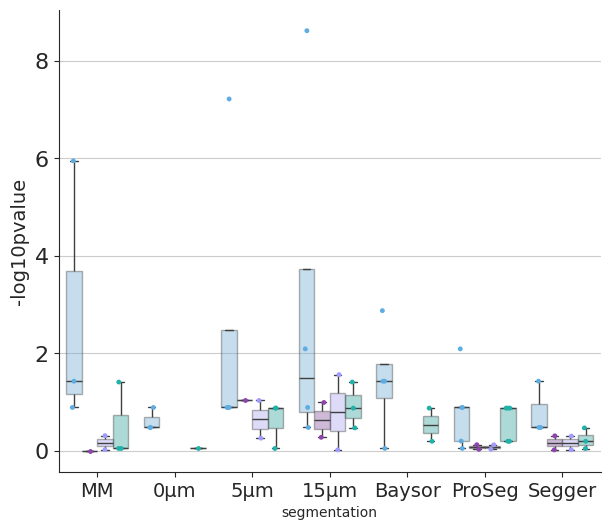

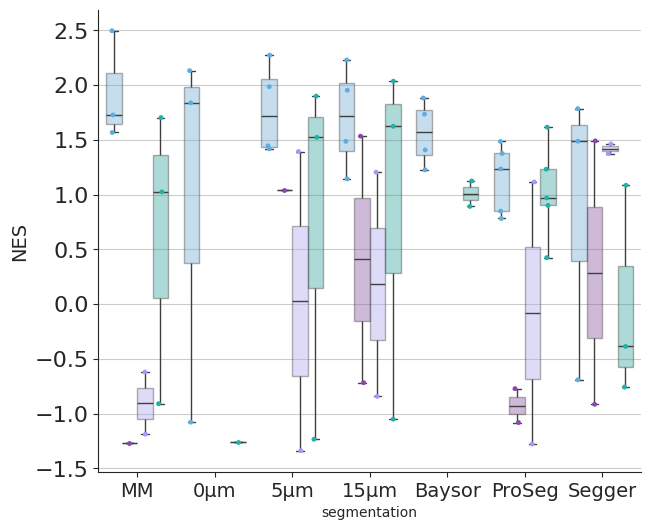

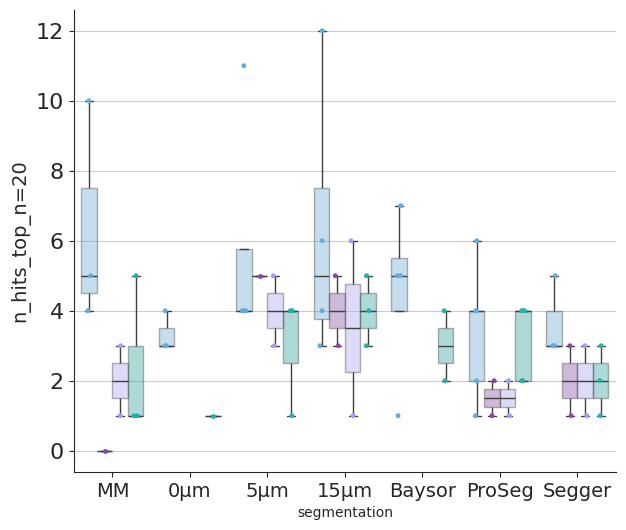

In [14]:
ref_panel = '5k'
cti = 'T cell'
ctj = 'malignant cell'
use_precomputed = True
n = 20
min_sample_size = None
min_sample_size_mode = 'specific'

if min_sample_size is not None:
    plot_metric_summary_stats = 'df_has_neighbor_counts'
    df_sample_sizes = _utils.get_df_summary_stats_plot(dfs_diffexpr,plot_metric=plot_metric_summary_stats)
    df_sample_sizes[f'{cti}_has_{ctj}_neighbor'] = _utils.extract_info_cell_type_pair(df_sample_sizes[plot_metric_summary_stats],cti,ctj,True)
    df_sample_sizes[f'{cti}_has_no_{ctj}_neighbor'] = _utils.extract_info_cell_type_pair(df_sample_sizes[plot_metric_summary_stats],cti,ctj,False)
    df_sample_sizes['min_class_sample_size'] = df_sample_sizes[[f'{cti}_has_{ctj}_neighbor',f'{cti}_has_no_{ctj}_neighbor']].min(1)
    
    unique_labels = [c for c in hue_correction_order if c in np.unique(df_sample_sizes[hue_correction].dropna())]
    unique_labels = unique_labels + [c for c in np.unique(df_sample_sizes[hue_correction].dropna()) if c not in unique_labels]
    palette = {u: count_correction_palette[u] for u in unique_labels}
    legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

    f = plt.figure(figsize=(10, 4))
    ax = plt.subplot()
    sns.boxplot(df_sample_sizes,x='segmentation',y='min_class_sample_size',
                hue=hue_correction, hue_order=unique_labels, 
                legend=False, palette=palette,ax=ax,
                order=[s for s in hue_segmentation_order if s in df_sample_sizes['segmentation'].unique()],
                boxprops={"alpha": 0.4},
                showfliers=False,
    )
    sns.stripplot(
        df_sample_sizes,
        x="segmentation",
        y='min_class_sample_size',
        hue=hue_correction,
        hue_order=unique_labels,
        legend=False,
        palette=palette,
        ax=ax,
        order=[s for s in hue_segmentation_order if s in df_sample_sizes["segmentation"].unique()],
        dodge=True,
        jitter=True,
        s=3.5,
    )

    sns.despine()

    plt.suptitle("Min class sample sizes",y=1.05)
    f.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=hue_correction,
        frameon=False,
    )
    plt.show()
    plt.close()


for rank_metric in rank_metrics:
    plot_metrics_ = plot_metrics[-1:] if rank_metric == 'mean_zscore' else plot_metrics
    for plot_metric in plot_metrics_:
        df = _utils.get_df_marker_rank_significance_plot(dfs['df_markers_rank_significance_logreg'],
                        rank_metric=rank_metric,plot_metric=plot_metric,
                        correction_methods=correction_methods,use_precomputed=use_precomputed,
                        n = n)

        df = df.query("panel == @ref_panel and cti == @cti and ctj == @ctj")
        if min_sample_size is not None:

            if min_sample_size_mode == 'all':
                result = df_sample_sizes.groupby(xenium_levels[1:])['min_class_sample_size'].min().reset_index()
                df = df.merge(result,on=xenium_levels[1:])
                df = df.query("min_class_sample_size >= @min_sample_size")

            elif min_sample_size_mode == 'specific':
                df = df.merge(df_sample_sizes,on=xenium_levels+['correction_method'])
                df = df.query("min_class_sample_size >= @min_sample_size")

        if plot_metric in ['hypergeometric_pvalue','mean_zscore_pvalue']:
            df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
            plot_metric = '-log10pvalue'

        # plotting params, palette
        title = f"Panel: {ref_panel}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}, {use_precomputed=}"
        unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
        unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
        palette = {u: count_correction_palette[u] for u in unique_labels}
        legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

        ### hypergeometric pvalue boxplot
        f = plt.figure(figsize=(7, 6))
        ax = plt.subplot()
        g = sns.boxplot(
            df,
            x="segmentation",
            y=plot_metric,
            hue=hue_correction,
            hue_order=unique_labels,
            legend=False,
            palette=palette,
            ax=ax,
            order=[s for s in hue_segmentation_order if s in df["segmentation"].unique()],
            # flierprops={
            #     "marker": "o",
            #     "color": "black",
            #     "markersize": 1,
            #     "markerfacecolor": "w",
            # },
            boxprops={"alpha": 0.4},
            showfliers=False,
        )
        sns.stripplot(
            df,
            x="segmentation",
            y=plot_metric,
            hue=hue_correction,
            hue_order=unique_labels,
            legend=False,
            palette=palette,
            ax=ax,
            order=[s for s in hue_segmentation_order if s in df["segmentation"].unique()],
            dodge=True,
            jitter=True,
            s=3.5,
        )

        sns.despine()
        ax.yaxis.grid(True)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=16)
        if plot_metric == '"-log10pvalue"':
            ax.set.ylabel(r"$-\log_{10} \text{ p-value}$", fontsize=14)
        else:
            ax.set_ylabel(plot_metric, fontsize=14)
        plt.show()
        plt.close()

In [ ]:
ref_segmentation = '10x_5um'
cti = 'T cell'
ctj = 'malignant cell'
use_precomputed = True

for rank_metric in rank_metrics:
    for plot_metric in plot_metrics:
        # extract df for rank_metric used for diffexpr and plot_metric used for GSEA/hypergeometric test
        df = _utils.get_df_marker_rank_significance_plot(dfs['df_markers_rank_significance_logreg'],
                        rank_metric=rank_metric,plot_metric=plot_metric,
                        correction_methods=correction_methods,use_precomputed=use_precomputed)
        
        df[plot_metric] = df[plot_metric].astype(float)
        
        if plot_metric == 'hypergeometric_pvalue':
            df['-log10pvalue'] = -np.log10(df[plot_metric])
            plot_metric = '-log10pvalue'

        u_condition_panel = df[['condition','panel']].drop_duplicates().values

        for condition,panel in u_condition_panel:

            df_plot = df.query(f"segmentation == '{ref_segmentation}' and condition == '{condition}' and panel == '{panel}'")
            df_plot = df_plot.groupby(['cti', 'ctj'])[plot_metric].mean().unstack()
            df_plot = df_plot.loc[df_plot.sum(1).sort_values(ascending=False).index]
            df_plot = df_plot[df_plot.sum(0).sort_values(ascending=False).index]

            title = f"Condition: {condition}, Panel: {panel}, Reference: {reference}, Method: {method}, Level: {level} \nrank metric: {rank_metric}, plot metric: {plot_metric}, {use_precomputed=}"

            f = plt.figure(figsize=(8,8))
            ax = plt.subplot()
            ax.set_title(title,fontsize=20)
            g = sns.heatmap(df_plot,cmap='coolwarm',center=-np.log10(0.05) if plot_metric == '-log10pvalue' else 0.)
            plt.show()

# Plot results permutation precision scores

In [ ]:
ref_panel = '5k'
cti = 'T cell'
ctj = 'malignant cell'

df = _utils.get_df_permutations_logreg_plot(dfs['df_permutations_logreg'],correction_methods)
df = df.query("panel == @ref_panel and cti == @cti and ctj == @ctj")
df['precision_difference'] = df['precision_score'] - df['perm_meanprecision_score']

df_palette = pd.read_csv(count_correction_palette, index_col=0).iloc[:, 0]

for plot_metric in ['precision_score','perm_meanprecision_score','precision_difference','p_value','effect_size']:
    if plot_metric in ['p_value']:
        df['-log10pvalue'] = -np.log10(df[plot_metric].astype(float))
        plot_metric = '-log10pvalue'

    # plotting params, palette
    title = f"Panel: {ref_panel}, Reference: {reference}, Method: {method}, Level: {level} \n{cti} contaminated by {ctj}\n rank metric: {rank_metric}, plot metric: {plot_metric}, {use_precomputed=}"
    unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
    unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
    palette = {u: df_palette[u] for u in unique_labels}
    legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

    ### hypergeometric pvalue boxplot
    f = plt.figure(figsize=(10, 4))
    ax = plt.subplot()
    g = sns.boxplot(df,x='segmentation',y=plot_metric, 
                    hue=hue_correction, hue_order=unique_labels, 
                    legend=False, palette=palette,ax=ax,
                    order=[s for s in hue_segmentation_order if s in df['segmentation'].unique()],
                    # log_scale=True
                    )

    sns.despine()
    ax.yaxis.grid(True)

    plt.suptitle(title,y=1.05)
    f.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=hue_correction,
        frameon=False,
    )
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
    plt.show()

# Plot sample sizes

In [ ]:
cti = 'T cell'
ctj = 'malignant cell'
ref_panel = 'lung'
plot_metric = 'df_has_neighbor_counts'


dfs_diffexpr = _utils.get_df_summary_stats_plot(dfs_diffexpr,plot_metric=plot_metric)
dfs_diffexpr = dfs_diffexpr.query("panel == @ref_panel")

dfs_diffexpr[f'{cti}_has_{ctj}_neighbor'] = _utils.extract_info_cell_type_pair(dfs_diffexpr[plot_metric],cti,ctj,True)
dfs_diffexpr[f'{cti}_has_no_{ctj}_neighbor'] = _utils.extract_info_cell_type_pair(dfs_diffexpr[plot_metric],cti,ctj,False)

# plotting params, palette
unique_labels = [c for c in hue_correction_order if c in np.unique(dfs_diffexpr[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(dfs_diffexpr[hue_correction].dropna()) if c not in unique_labels]
# palette = {u: palette[u] for u in unique_labels}
palette = dict(zip(unique_labels,sns.palettes.hls_palette(len(unique_labels))))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

###  boxplot
for y in [f'{cti}_has_{ctj}_neighbor',f'{cti}_has_no_{ctj}_neighbor']:

    title = f"{y} for {ref_panel}"

    f = plt.figure(figsize=(10, 4))
    ax = plt.subplot()
    g = sns.boxplot(dfs_diffexpr,x='segmentation',y=y, 
                    hue=hue_correction, hue_order=unique_labels, 
                    legend=False, palette=palette,ax=ax,
                    # order=[s for s in hue_segmentation_order if s in dfs_diffexpr['segmentation'].unique()],
                    log_scale=True,
                    showfliers=True
                    )

    sns.despine()
    ax.yaxis.grid(True)
    plt.xticks(rotation=45, ha='right')

    plt.suptitle(title)
    f.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=hue_correction,
        frameon=False,
    )

# Plot rankings

In [60]:
from matplotlib.patches import Patch

# df_ctj_marker_genes = _utils.get_df_ctj_marker_genes(dfs['df_ctj_marker_genes'],correction_methods)
cti = 'T cell'
ctj = 'malignant cell'

top_n = 40
lung_genes_only = True
list_mode = ['importances','diffexpr']
list_ref_panels = ['lung','5k','breast']
list_rank_method = ['mean']
list_scale_method = ['abssum']
list_ref_segmentations = ['5µm','ProSeg']
keep_annotations = [
    'T cell', 
    'canonical T cell marker',
    'regulatory T cell',
    'exhausted T cell',
    'cytotoxic T cell',
    'immune response',
    'proliferation',
    'malignant cell',
    'fibroblast', 
    'epithelial cell'
    ]

palette = {
    'T cell': '#2ECC71',
    'canonical T cell marker': '#1ABC9C',
    'regulatory T cell': '#17A589',
    'exhausted T cell': '#2980B9',
    'cytotoxic T cell': '#3498DB',
    'immune response': '#5D6D7E',
    'proliferation': '#E67E22',
    'malignant cell': '#C0392B',
    'fibroblast': '#9B59B6',
    'epithelial cell': '#F1C40F',
    'Other': '#FFFFFF'
}


for mode, ref_panel, rank_method, scale_method in itertools.product(list_mode, list_ref_panels, list_rank_method, list_scale_method):

    # define gene labels
    if ref_panel in ['lung','5k']:
        gene_labels = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata_DB.csv',encoding='latin1')[['Gene','Annotation_DB']]
    elif ref_panel == 'breast':
        gene_labels = pd.read_csv(cfg['markers_dir']+'Xenium_hBreast_v1_metadata_DB.csv',encoding='latin1')[['Genes','Annotation_DB']]
    gene_labels.columns = ['Gene','Label']
    gene_labels.loc[~gene_labels['Label'].isin(keep_annotations),'Label'] = 'Other'
    gene_labels = gene_labels.set_index('Gene')['Label'].to_dict()

    # load data
    if mode =='importances':
        df_importances_logreg = _utils.get_df_importances_cti_ctj(dfs['df_importances_logreg'], cti, ctj, ref_panel, correction_methods)

        # scale data
        df_norm = df_importances_logreg.copy()
        if scale_method == 'abssum':
            df_norm.iloc[:,8:] =  df_norm.iloc[:,8:].div(df_norm.iloc[:,8:].abs().sum(axis=1),axis=0)
        elif scale_method == 'zscore':
            df_norm.iloc[:,8:] =  zscore(df_norm.iloc[:,8:],axis=0)

    elif mode =='diffexpr':
        df_diffexpr = _utils.get_df_diffexpr_cti_ctj(dfs_diffexpr['df_diffexpr'], cti, ctj, ref_panel, correction_methods, rank_metric='logfoldchanges')
        df_norm = df_diffexpr.copy()

    # filter data
    if ref_panel == '5k' and lung_genes_only:
        lung_panel_genes = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
        retain_cols = df_norm.columns[:8].tolist()+[g for g in lung_panel_genes if g in df_norm.columns]
        df_norm = df_norm[retain_cols]

    # --- Identify metadata and importance (gene) columns in df_norm ---
    metadata_cols = ['correction_method', 'segmentation', 'condition', 'panel', 'donor', 'sample', 'cti', 'ctj']
    importance_cols = df_norm.columns.difference(metadata_cols, sort=False).tolist()

    for ref_segmentation in list_ref_segmentations:
        
        # --- Get unique combinations of grouping variables ---
        groups = [[g,ref_segmentation] for g in hue_correction_order]
        num_groups = len(groups)

        # --- Setup Subplots ---
        ncols = num_groups
        nrows = 1

        base_width_per_plot = 3  # Adjust as needed
        base_height_per_plot = 7 # Taller for vertical plots with rotated labels
        fig_width = base_width_per_plot * ncols
        fig_height = base_height_per_plot * nrows

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height),squeeze=False) # Ensure axes is always 2D
        axes_flat = axes.flatten()

        # --- Generate plot for each group ---
        for i, group_vals in enumerate(groups):
            correction_method, segmentation = group_vals
            ax = axes_flat[i]

            # 1. Filter df_norm for the current group
            group_df = df_norm[
                (df_norm['correction_method'] == correction_method) &
                (df_norm['segmentation'] == segmentation)
            ].copy() # Use .copy() to avoid SettingWithCopyWarning later
        
            group_importances = group_df[importance_cols]
            if rank_method == 'mean':
                overall_importances = group_importances.mean(axis=0).dropna()
            elif rank_method == 'median':
                overall_importances = group_importances.median(axis=0).dropna()

            n_top = min(top_n, len(overall_importances))
            top_genes = overall_importances.nlargest(n_top).index.tolist()
            # top_genes = df_labeling_info['Gene'].values

            # 3. Prepare data for plotting: Melt and Add Labels
            # Ensure only top genes are selected *before* melting
            melt_data = group_df[top_genes]
            plot_data_long = melt_data.melt(
                var_name='Gene',
                value_name='Importance'
            )

            # **** Add the 'Label' column for coloring ****
            plot_data_long['Label'] = plot_data_long['Gene'].map(gene_labels)
            # Handle genes that might be missing a label
            plot_data_long['Label'] = plot_data_long['Label'].fillna('Other')

            # Check if any labels were actually assigned
            hue_param = 'Label'

            sns.boxplot(
                data=plot_data_long,
                x='Importance',          # Genes on X-axis -> Vertical boxes
                y='Gene',    # Values on Y-axis
                hue=hue_param,     # Color by the 'Label' column
                order=top_genes,   # Order genes by mean importance
                palette=palette, # Use the defined label-color mapping
                dodge=False,       # Don't shift boxes for hue, color the whole box
                ax=ax,             # Draw on the correct subplot axis
                fliersize=1.5,
                legend=False
            )

            # 5. Customize the SUBPLOT
            ax.set_title(f'{correction_method}\n{segmentation}', fontsize=10)
            ax.grid(axis='x', linestyle='--', alpha=0.6)
            ax.axvline(0.0, color='k', linestyle='-', zorder=-1, alpha=0.5)
            if mode == 'diffexpr':
                ax.set_xlabel('Log fold-change', fontsize=9)
            else:
                ax.set_xlabel('Importance Score', fontsize=9)

            if i % ncols == 0:
                ax.set_ylabel('Gene', fontsize=9)
            else:
                ax.set_ylabel('')


        # Adjust legend position
        handles = [Patch(facecolor=color, label=label) for label, color in palette.items()]
        fig.legend(handles=handles, labels=list(palette.keys()), title="Gene Label",
                    bbox_to_anchor=(.94, 0.5), loc='upper left', fontsize=9, title_fontsize=10)
        fig.tight_layout(rect=[0, 0.03, 0.95, 0.95]) 

        # save
        Path(f"../../scratch/rankings_{mode}").mkdir(parents=True, exist_ok=True)
        plt.savefig(f"../../scratch/rankings_{mode}/rankings_{mode}_{ref_panel=}_{ref_segmentation=}_{rank_method=}_{scale_method=}_{cti}_{ctj}.png",bbox_inches='tight',dpi=300)
        plt.close()

    #     if ref_panel == 'lung' and ref_segmentation == '5µm' and correction_method=='SPLIT':
    #         break
    # break

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:686: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:687: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj), rank_metric]
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:686: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:687: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj), rank_metric]
/work/PRTNR/CHUV/DIR/r

# Plot rankings SPLIT only

In [56]:
df_ctj_marker_genes = _utils.get_df_ctj_marker_genes(dfs['df_ctj_marker_genes'],correction_methods)
cti = 'T cell'
ctj = 'malignant cell'
ref_panel = 'lung'
n = 20

malignant_markers = df_ctj_marker_genes.query("cell_type == @ctj and correction_method == 'raw' and segmentation == '10x_5um'")['gene'].value_counts()[:n].index
t_cell_markers = df_ctj_marker_genes.query("cell_type == @cti and correction_method == 'raw' and segmentation == '10x_5um'")['gene'].value_counts()[:n].index


df = {}
for correction_method in correction_methods:
    for k, v in dfs['df_importances_logreg'][correction_method].items():
        if k[2] != ref_panel:
            continue
        # for (cti,ctj) in v.index.droplevel(2).unique():
        if (cti,ctj) in v.index:
            df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj),'importances']

df = pd.DataFrame(df).T.reset_index()
df.columns = ["correction_method"] + xenium_levels + ["cti", "ctj"] + df.columns[8:].tolist()
_utils.rename_methods(df)

df_norm = df.copy()
df_norm.iloc[:,8:] =  df.iloc[:,8:].div(df.iloc[:,8:].abs().sum(axis=1),axis=0)

/tmp/ipykernel_2562492/3624568730.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti,ctj) in v.index:
/tmp/ipykernel_2562492/3624568730.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj),'importances']


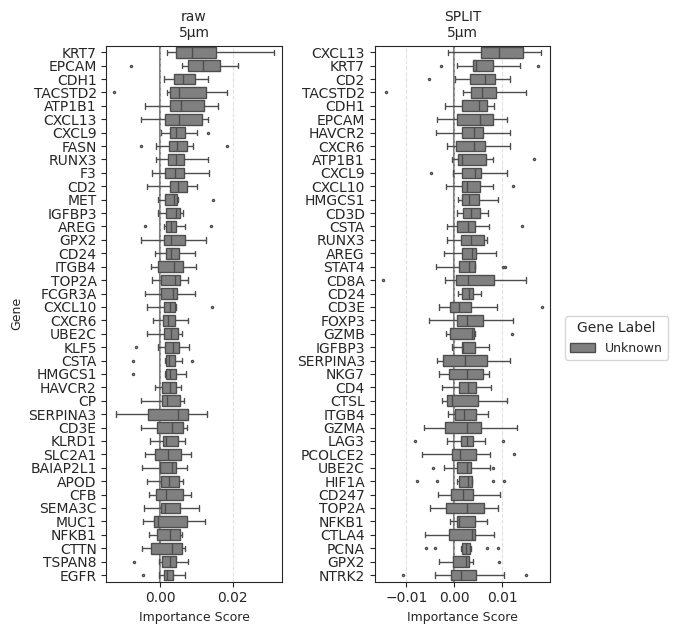

In [53]:
df_labeling_info = pd.DataFrame(columns=['Gene', 'Label'])
df_labeling_info['Gene'] = df_norm.columns[8:]
df_labeling_info['Label'] = 'unknown'

ctj_markers = [g for g in malignant_markers if g in df_labeling_info.Gene.values]
cti_markers = [g for g in t_cell_markers if g in df_labeling_info.Gene.values]
df_labeling_info.loc[df_labeling_info['Gene'].isin(ctj_markers), 'Label'] = 'malignant cell'
df_labeling_info.loc[df_labeling_info['Gene'].isin(cti_markers), 'Label'] = 'T cell'
df_labeling_info = df_labeling_info.query("Label != 'unknown'")

# --- Prepare Labeling Info ---
# Create a dictionary for quick lookup: Gene -> Label
gene_to_label = pd.Series(df_labeling_info.Label.values, index=df_labeling_info.Gene).to_dict()

# Define a color palette for the labels (important for consistency)
unique_labels = df_labeling_info['Label'].unique()
palette_name = 'tab10' 
colors = sns.color_palette(palette_name, n_colors=len(unique_labels))
label_palette = dict(zip(unique_labels, colors))


# --- Identify metadata and importance (gene) columns in df_norm ---
metadata_cols = ['correction_method', 'segmentation', 'condition', 'panel', 'donor', 'sample', 'cti', 'ctj']
importance_cols = df_norm.columns.difference(metadata_cols, sort=False).tolist()

hue_correction_order_SPLIT = ['raw','SPLIT']

df_top = {}

for segmentation in list_ref_segmentations[:1]:
    # --- Get unique combinations of grouping variables ---
    groups = [[g,segmentation] for g in hue_correction_order_SPLIT]
    num_groups = len(groups)

    # --- Setup Subplots ---
    ncols = num_groups
    nrows = 1

    base_width_per_plot = 3  # Adjust as needed
    base_height_per_plot = 7 # Taller for vertical plots with rotated labels
    fig_width = base_width_per_plot * ncols
    fig_height = base_height_per_plot * nrows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height),squeeze=False) # Ensure axes is always 2D
    axes_flat = axes.flatten()

    # --- Generate plot for each group ---
    plot_handles, plot_labels = [], [] # To collect handles/labels for a single legend

    for i, group_vals in enumerate(groups):
        correction_method, segmentation = group_vals
        ax = axes_flat[i]

        # 1. Filter df_norm for the current group
        group_df = df_norm[
            (df_norm['correction_method'] == correction_method) &
            (df_norm['segmentation'] == segmentation)
        ].copy() # Use .copy() to avoid SettingWithCopyWarning later
    
        group_importances = group_df[importance_cols]
        mean_importances = group_importances.mean(axis=0).dropna()
        n_top = min(40, len(mean_importances))
        top_genes = mean_importances.nlargest(n_top).index.tolist()
        # top_genes = df_labeling_info['Gene'].values

        # 3. Prepare data for plotting: Melt and Add Labels
        # Ensure only top genes are selected *before* melting
        melt_data = group_df[top_genes]
        plot_data_long = melt_data.melt(
            var_name='Gene',
            value_name='Importance'
        )

        # **** Add the 'Label' column for coloring ****
        plot_data_long['Label'] = plot_data_long['Gene'].map(gene_to_label)
        # Handle genes that might be missing a label
        plot_data_long['Label'] = plot_data_long['Label'].fillna('Unknown')
        # Ensure 'Unknown' has a color if it arises
        if 'Unknown' not in label_palette and 'Unknown' in plot_data_long['Label'].unique():
                label_palette['Unknown'] = '#808080' # Add grey for unknown

        # Check if any labels were actually assigned
        hue_param = 'Label'
        palette_param = label_palette

        sns.boxplot(
            data=plot_data_long,
            x='Importance',          # Genes on X-axis -> Vertical boxes
            y='Gene',    # Values on Y-axis
            hue=hue_param,     # Color by the 'Label' column
            order=top_genes,   # Order genes by mean importance
            palette=palette_param, # Use the defined label-color mapping
            dodge=False,       # Don't shift boxes for hue, color the whole box
            ax=ax,             # Draw on the correct subplot axis
            fliersize=1.5
        )

        # 5. Customize the SUBPLOT
        ax.set_title(f'{correction_method}\n{segmentation}', fontsize=10)
        # ax.tick_params(axis='x', rotation=90, labelsize=8)
        # ax.tick_params(axis='y', labelsize=8)
        ax.grid(axis='x', linestyle='--', alpha=0.6)
        ax.axvline(0.0, color='k', linestyle='-', zorder=-1, alpha=0.5)
        ax.set_xlabel('Importance Score', fontsize=9)

        if i % ncols == 0:
            ax.set_ylabel('Gene', fontsize=9)
        else:
            ax.set_ylabel('')

        # Remove individual subplot legends if hue was used (will create one below)
        if hue_param:
                # Collect handles/labels from the first plot that has a legend
                if not plot_labels and ax.get_legend() is not None:
                    handles, labels = ax.get_legend_handles_labels()
                    # Use a dictionary to ensure unique labels/handles
                    unique_hl = dict(zip(labels, handles))
                    plot_handles = list(unique_hl.values())
                    plot_labels = list(unique_hl.keys())

                if ax.get_legend() is not None:
                    ax.get_legend().remove()


    # --- Final Plot Adjustments ---
    # Hide unused subplots
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    # Add a single legend for the whole figure if labels were used
    # Adjust legend position: place it outside the top right corner
    fig.legend(handles=plot_handles, labels=plot_labels, title="Gene Label",
                bbox_to_anchor=(.94, 0.5), loc='upper left', fontsize=9, title_fontsize=10)

    # plt.suptitle('Top 20 Feature Importances per Condition', fontsize=16, y=.95)
    # Adjust layout carefully to make space for suptitle and potential legend
    fig.tight_layout(rect=[0, 0.03, 0.95, 0.95]) # Adjust right margin for legend if needed (e.g., 0.9 or 0.85)
    plt.show()

# Get rankings SPLIT only

In [ ]:
def get_df_ctj_marker_genes(dfs_ctj_marker_genes, correction_methods,):
    df_ctj_marker_genes = {}
    for correction_method in correction_methods:
        for k, v in dfs['df_ctj_marker_genes'][correction_method].items():
            for ctj in v.columns:
                df_ctj_marker_genes[(correction_method,*k,ctj)] = v[ctj]

    df_ctj_marker_genes = pd.concat(df_ctj_marker_genes).reset_index().drop('level_7',axis=1)
    df_ctj_marker_genes.columns = ['correction_method'] + xenium_levels + ['cell_type','gene']
    return df_ctj_marker_genes


df_ctj_marker_genes = get_df_ctj_marker_genes(dfs['df_ctj_marker_genes'],correction_methods)
ctj = 'malignant cell'
ref_panel = 'lung'
n = 20


df = {}
for correction_method in correction_methods:
    for k, v in dfs['df_importances_logreg'][correction_method].items():
        if k[2] != ref_panel:
            continue
        
        u_cell_types_combs = v.index.droplevel(2).unique()
        u_cell_types_combs_ctj = [x for x in u_cell_types_combs if x[1] == ctj]
        for (cti_,ctj_) in u_cell_types_combs_ctj:
        # if (cti,ctj) in v.index:
            df[(correction_method, *k, cti_, ctj_)] = v.loc[(cti_, ctj_),'importances']

df = pd.DataFrame(df).T.reset_index()
df.columns = ["correction_method"] + xenium_levels + ["cti", "ctj"] + df.columns[8:].tolist()
_utils.rename_methods(df)

df_norm = df.copy()
df_norm.iloc[:,8:] =  df.iloc[:,8:].div(df.iloc[:,8:].abs().sum(axis=1),axis=0)

In [ ]:
df_labeling_info = pd.DataFrame(columns=['Gene', 'Label'])
df_labeling_info['Gene'] = df_norm.columns[8:]
df_labeling_info['Label'] = 'unknown'

ctj_markers = [g for g in malignant_markers if g in df_labeling_info.Gene.values]
cti_markers = [g for g in t_cell_markers if g in df_labeling_info.Gene.values]
df_labeling_info.loc[df_labeling_info['Gene'].isin(ctj_markers), 'Label'] = 'malignant cell'
df_labeling_info.loc[df_labeling_info['Gene'].isin(cti_markers), 'Label'] = 'T cell'
df_labeling_info = df_labeling_info.query("Label != 'unknown'")

# --- Prepare Labeling Info ---
# Create a dictionary for quick lookup: Gene -> Label
gene_to_label = pd.Series(df_labeling_info.Label.values, index=df_labeling_info.Gene).to_dict()

# Define a color palette for the labels (important for consistency)
unique_labels = df_labeling_info['Label'].unique()
palette_name = 'tab10' 
colors = sns.color_palette(palette_name, n_colors=len(unique_labels))
label_palette = dict(zip(unique_labels, colors))


# --- Identify metadata and importance (gene) columns in df_norm ---
metadata_cols = ['correction_method', 'segmentation', 'condition', 'panel', 'donor', 'sample', 'cti', 'ctj']
importance_cols = df_norm.columns.difference(metadata_cols, sort=False).tolist()

hue_correction_order_SPLIT = ['raw','SPLIT']

df_top = {}

groups = df_norm[['cti','ctj','correction_method','segmentation']].drop_duplicates().values

for i, group_vals in enumerate(groups):
    cti, ctj, correction_method, segmentation = group_vals

    # 1. Filter df_norm for the current group
    group_df = df_norm[
        (df_norm['cti'] == cti) &
        (df_norm['ctj'] == ctj) &
        (df_norm['correction_method'] == correction_method) &
        (df_norm['segmentation'] == segmentation)
    ].copy() # Use .copy() to avoid SettingWithCopyWarning later

    group_importances = group_df[importance_cols]
    mean_importances = group_importances.mean(axis=0).dropna()
    n_top = min(40, len(mean_importances))
    top_genes = mean_importances.nlargest(n_top).index.tolist()
    # top_genes = df_labeling_info['Gene'].values

    df_top[cti, ctj, segmentation, correction_method] = top_genes
    
df_top = pd.DataFrame(df_top)
df_top.to_csv('../../scratch/df_top_markers.csv')

# Heatmap diffexpr

In [ ]:
### params
df_ctj_marker_genes = _utils.get_df_ctj_marker_genes(dfs['df_ctj_marker_genes'],correction_methods)
cti = 'T cell'
ctj = 'malignant cell'
lung_genes_only = True
top_n = 20
agg_func='median'
rank_metric='logfoldchanges'
rank_metric_pvals='pvals_adj'
rank_metric_logreg='importances'

list_ref_panel = ['lung','5k']
list_ref_segmentation = ['5µm','ProSeg']
list_scale = ['row','column']
list_show_pvals = [True,False]

Path('../../scratch/heatmaps/').mkdir(parents=True, exist_ok=True)
for ref_panel, ref_segmentation, scale, show_pvals in itertools.product(list_ref_panel,list_ref_segmentation, list_scale, list_show_pvals):

    if ref_panel == '5k' and ref_segmentation == '5µm':
        ref_segmentation = 'MM'

    #### extract data into df
    df_diffexpr = _utils.get_df_diffexpr_cti_ctj(dfs_diffexpr['df_diffexpr'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric)
    df_diffexpr_pvals = _utils.get_df_diffexpr_cti_ctj(dfs_diffexpr['df_diffexpr'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric_pvals)
    df = _utils.get_df_importances_cti_ctj(dfs['df_importances_logreg'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric_logreg)

    id_vars = df.columns[:8].tolist()
    value_vars = df.columns[8:].tolist()

    df_diffexpr_norm = df_diffexpr.copy()
    df_norm = df.copy()
    if ref_panel == '5k' and lung_genes_only:
        lung_panel_genes = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
        value_vars = [g for g in lung_panel_genes if g in df_norm.columns]
        df_norm = df_norm[id_vars+value_vars]

    # optionally normalize values
    scale_axis = 0 if scale=='column' else 1
    df_diffexpr_norm[value_vars] = df_diffexpr_norm[value_vars].replace(np.nan,0)
    df_diffexpr_norm[value_vars] =  zscore(df_diffexpr[value_vars],axis=scale_axis,nan_policy='omit')# df_diffexpr[value_vars].div(df_diffexpr[value_vars].abs().sum(axis=1),axis=0)
    df_norm[value_vars] =  df[value_vars].div(df[value_vars].abs().sum(axis=1),axis=0)
    # df_norm[value_vars] = df[value_vars].div(df[value_vars].abs().rank(axis=1, ascending=True),axis=0)


    ### get median top n genes for each unique correction/segmentation/condition/panel
    if top_n is not None:
        id_vars_rank = ['correction_method', 'segmentation', 'condition', 'panel']

        df_top_genes = (
            df_norm.groupby(list(id_vars_rank))
            .apply(lambda g: get_top_n_genes(g, n=top_n, value_vars=value_vars,agg_func=agg_func))
            .reset_index()
        )
        df_top_genes.columns = id_vars_rank + ['top_genes']
        value_vars = list(set().union(*df_top_genes['top_genes']))
        df_norm = df_norm[id_vars+value_vars]

    ### define plot df
    df_plot = df_diffexpr_norm.melt(id_vars=id_vars,     
                            value_vars=value_vars,  
                            var_name='gene',                 
                            value_name=rank_metric)

    df_plot_pvals = df_diffexpr_pvals.melt(id_vars=id_vars,     
                            value_vars=value_vars,  
                            var_name='gene',                 
                            value_name=rank_metric_pvals)

    df_plot = pd.merge(df_plot,df_plot_pvals,on=id_vars+['gene'])
    df_plot[rank_metric_pvals] = -np.log10(df_plot_pvals[rank_metric_pvals].clip(1e-20,1))

    df_plot['ID'] = df_plot[id_vars].astype(str).agg('-'.join, axis=1)
    df_plot = df_plot.query(f"segmentation == '{ref_segmentation}'")
    df_plot['gene_label'] = df_plot['gene'].map(gene_labels_reverse)
    df_plot['gene_label'] = df_plot['gene_label'].fillna('Other')

    ### palettes
    unique_labels = [c for c in hue_correction_order if c in np.unique(df_plot[hue_correction].dropna())]
    unique_labels = unique_labels + [c for c in np.unique(df_plot[hue_correction].dropna()) if c not in unique_labels]
    palette = {u: count_correction_palette[u] for u in unique_labels}


    ### heatmap row/col labels
    df_col=df_plot[['segmentation','correction_method','panel','ID']].drop_duplicates()#.to_frame()
    df_col.set_index('ID',inplace=True)

    df_row=df_plot[['gene','gene_label']].drop_duplicates()
    df_row.set_index('gene',inplace=True)

    row_ha = HeatmapAnnotation(
                            gene_label=anno_simple(df_row['gene_label'],cmap='tab20',add_text=False,legend=True),
                            label=anno_label(df_row['gene_label'],cmap='tab20', merge=True,rotation=0,arrowprops = dict(visible=False)),
                            label_side='top',label_kws={'rotation':30,'horizontalalignment':'left'},
                            axis=0,verbose=0)


    col_ha = HeatmapAnnotation(
        correction_method=anno_simple(df_col['correction_method'], colors=count_correction_palette.to_dict(),legend=True,add_text=True),
        # panel=anno_simple(df_col['panel'], cmap='Dark2',legend=False,add_text=True),
        # segmentation=anno_simple(df_col['segmentation'], cmap='Set1',legend=False,add_text=True),
        verbose=0,label_side='left')


    ### heatmap 
    plt.figure(figsize=(10, 25))
    cm = DotClustermapPlotter(
        data=df_plot, 
        x='ID',y='gene',value=rank_metric,c=rank_metric,
        s=rank_metric_pvals if show_pvals else None,
        row_cluster=True,col_cluster=False,
        #hue='EnrichType', 
        #cmap={'Enrich':'RdYlGn_r','Depletion':'coolwarm_r'},
        #colors={'Enrich':'red','Depletion':'blue'},
        #marker={'Enrich':'^','Depletion':'v'},
        top_annotation=col_ha,
        right_annotation=row_ha,
        col_split=df_col['correction_method'],
        col_split_order=hue_correction_order,
        row_split=df_row['gene_label'], 
        row_split_order=[k for k in gene_labels.keys() if k in df_row['gene_label'].unique()],

        cmap='bwr',center=0,
        col_split_gap=2,row_split_gap=5,
        show_rownames=True,show_colnames=False,row_dendrogram=False,
        verbose=1,legend_gap=10,grid=None,linewidths=.01,spines=True,
        vmin=-4,vmax=4,
        ) #if the size of dot in legend is too large, use alpha to control, for example: alpha=0.8

    # plt.savefig(f"../../scratch/heatmaps/heatmap_{ref_panel=}_{ref_segmentation=}_{scale=}_{show_pvals=}.pdf",bbox_inches='tight',dpi=300)
    plt.show()

    break

# Heatmap diffexpr separate scales

In [44]:
### params
keep_annotations = [
    'T cell', 
    'canonical T cell marker',
    'regulatory T cell',
    'exhausted T cell',
    'cytotoxic T cell',
    'immune response',
    'proliferation',
    'malignant cell',
    'fibroblast', 
    'epithelial cell'
    ]
gene_labels = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata_DB.csv',encoding='latin1').groupby('Annotation_DB')['Gene'].agg(list)
# gene_labels = gene_labels[gene_labels.map(lambda x: len(x))>2].to_dict()
gene_labels = {k:gene_labels[k] for k in keep_annotations}
gene_labels_reverse = {v:k for k,vs in gene_labels.items() for v in vs}

In [ ]:
### params
df_ctj_marker_genes = _utils.get_df_ctj_marker_genes(dfs['df_ctj_marker_genes'],correction_methods)
cti = 'T cell'
ctj = 'malignant cell'
lung_genes_only = True
top_n = None
agg_func='median'
rank_metric='logfoldchanges'
rank_metric_pvals='pvals'
rank_metric_logreg='importances'

list_ref_panel = ['breast'] #['lung','5k']
list_ref_segmentation = ['5µm','ProSeg']
list_show_pvals = [True]

Path('../../scratch/heatmaps/').mkdir(parents=True, exist_ok=True)
for ref_panel, ref_segmentation, show_pvals in itertools.product(list_ref_panel,list_ref_segmentation, list_show_pvals):

    if ref_panel == '5k' and ref_segmentation == '5µm':
        ref_segmentation = 'MM'
        # continue

    #### extract data into df
    df_diffexpr = _utils.get_df_diffexpr_cti_ctj(dfs_diffexpr['df_diffexpr'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric)
    df_diffexpr_pvals = _utils.get_df_diffexpr_cti_ctj(dfs_diffexpr['df_diffexpr'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric_pvals)
    df = _utils.get_df_importances_cti_ctj(dfs['df_importances_logreg'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric_logreg)

    id_vars = df.columns[:8].tolist()
    value_vars = df.columns[8:].tolist()

    df_diffexpr_norm = df_diffexpr.copy()
    df_norm = df.copy()
    if ref_panel == '5k' and lung_genes_only:
        lung_panel_genes = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
        value_vars = [g for g in lung_panel_genes if g in df_norm.columns]
        df_norm = df_norm[id_vars+value_vars]

    df_diffexpr_norm[value_vars] = df_diffexpr_norm[value_vars].replace(np.nan,0)
    # df_diffexpr_norm[value_vars] =  zscore(df_diffexpr[value_vars],axis=scale_axis,nan_policy='omit')# df_diffexpr[value_vars].div(df_diffexpr[value_vars].abs().sum(axis=1),axis=0)
    # df_norm[value_vars] =  df[value_vars].div(df[value_vars].abs().sum(axis=1),axis=0)
    # df_norm[value_vars] = df[value_vars].div(df[value_vars].abs().rank(axis=1, ascending=True),axis=0)


    ### get median top n genes for each unique correction/segmentation/condition/panel
    if top_n is not None:
        id_vars_rank = ['correction_method', 'segmentation', 'condition', 'panel']

        df_top_genes = (
            df_norm.groupby(list(id_vars_rank))
            .apply(lambda g: get_top_n_genes(g, n=top_n, value_vars=value_vars,agg_func=agg_func))
            .reset_index()
        )
        df_top_genes.columns = id_vars_rank + ['top_genes']
        value_vars = list(set().union(*df_top_genes['top_genes']))
        df_norm = df_norm[id_vars+value_vars]

    ### define plot df
    df_plot = df_diffexpr_norm.melt(id_vars=id_vars,     
                            value_vars=value_vars,  
                            var_name='gene',                 
                            value_name=rank_metric)

    df_plot_pvals = df_diffexpr_pvals.melt(id_vars=id_vars,     
                            value_vars=value_vars,  
                            var_name='gene',                 
                            value_name=rank_metric_pvals)


    
    df_plot = pd.merge(df_plot,df_plot_pvals,on=id_vars+['gene'])

    # replace nan values
    df_plot[rank_metric] = df_plot[rank_metric].replace(np.nan,0.)
    df_plot[rank_metric_pvals] = df_plot[rank_metric_pvals].replace(np.nan,1.)

    # clip 
    df_plot[rank_metric_pvals] = -np.log10(df_plot[rank_metric_pvals].clip(1e-10,1))
    # df_plot[rank_metric_pvals] += 1e-2*np.abs(np.random.random((len(df_plot[rank_metric_pvals]))))

    df_plot['ID'] = df_plot[id_vars].astype(str).agg('-'.join, axis=1)
    df_plot = df_plot.query(f"segmentation == '{ref_segmentation}'")
    df_plot['gene_label'] = df_plot['gene'].map(gene_labels_reverse)
    df_plot['gene_label'] = df_plot['gene_label'].fillna('Other')

    ### palettes
    unique_labels = [c for c in hue_correction_order if c in np.unique(df_plot[hue_correction].dropna())]
    unique_labels = unique_labels + [c for c in np.unique(df_plot[hue_correction].dropna()) if c not in unique_labels]
    palette = {u: count_correction_palette[u] for u in unique_labels}

    ### heatmap 
    cmlist=[]
    for i, correction_method in enumerate(hue_correction_order):

        idx_correction_method = df_plot['correction_method'] == correction_method
        if not sum(idx_correction_method):
            continue
        
        df_plot_corr_method = df_plot[idx_correction_method].copy()
        df_plot_corr_method[f'{correction_method}\nlogFC']=df_plot_corr_method[rank_metric]
        # df_plot_corr_method[rank_metric_pvals] = df_plot_corr_method[rank_metric_pvals]+1e-30*np.random.random((len(df_plot_corr_method[rank_metric_pvals])))

        df_col=df_plot_corr_method[['segmentation','correction_method','panel','ID']].drop_duplicates()#.to_frame()
        df_col.set_index('ID',inplace=True)

        df_row=df_plot_corr_method[['gene','gene_label']].drop_duplicates()
        df_row.set_index('gene',inplace=True)

        # display params
        vmin, vmax = winsorize_asymmetric(df_plot_corr_method[rank_metric],neg_q=0.1, pos_q=0.9)
        vmin = np.maximum(-10,vmin)
        vmax = np.minimum(10,vmax)

        if abs(vmin) > (10*vmax):
            vmin = -5*abs(vmax)
        if vmax > (10*abs(vmin)):
            vmax = (5*abs(vmin))


        show_rownames = True if i == 0 else False

        if show_pvals:
            if len(df_plot_corr_method[rank_metric_pvals].unique()) < 2:
                s = 1.
            else:
                s = rank_metric_pvals
        else:
            s = None

        if i == len(hue_correction_order)-1:
            row_ha = HeatmapAnnotation(
                                    gene_label=anno_simple(df_row['gene_label'],cmap='tab20',add_text=False,legend=True),
                                    label=anno_label(df_row['gene_label'],cmap='tab20', merge=True,rotation=0,arrowprops = dict(visible=False)),
                                    label_side='top',label_kws={'rotation':30,'horizontalalignment':'left'},
                                    axis=0,verbose=0)
        else:
            row_ha = None
        
        col_ha = HeatmapAnnotation(
            correction_method=anno_simple(df_col['correction_method'], colors=count_correction_palette.to_dict(),legend=True,add_text=True),
            # panel=anno_simple(df_col['panel'], cmap='Dark2',legend=False,add_text=True),
            # segmentation=anno_simple(df_col['segmentation'], cmap='Set1',legend=False,add_text=True),
            verbose=0,label_kws={'visible':False})


        ### heatmap
        cm = DotClustermapPlotter(
            data=df_plot_corr_method, 
            x='ID',y='gene',value=f'{correction_method}\nlogFC',c=f'{correction_method}\nlogFC',
            s=rank_metric_pvals if show_pvals else None,
            row_cluster=False,col_cluster=False,
            #hue='EnrichType', 
            #cmap={'Enrich':'RdYlGn_r','Depletion':'coolwarm_r'},
            #colors={'Enrich':'red','Depletion':'blue'},
            #marker={'Enrich':'^','Depletion':'v'},
            top_annotation=col_ha,
            right_annotation=row_ha,
            # col_split=df_col_corr_method['correction_method'],
            # col_split_order=hue_correction_order,
            row_split=df_row['gene_label'], 
            row_split_order=[k for k in gene_labels.keys() if k in df_row['gene_label'].unique()],

            cmap='bwr',
            center=0,
            label='correction_method',
            col_split_gap=2,row_split_gap=5,
            show_rownames=show_rownames,
            row_names_side='left',
            show_colnames=False,row_dendrogram=False,
            verbose=0,legend_gap=10,grid=None,linewidths=.01,spines=True,
            vmin=vmin,
            vmax=vmax,
            # vmin=df_plot_corr_method[f'{correction_method}\nlogFC'].quantile(0.08),
            # vmax=df_plot_corr_method[f'{correction_method}\nlogFC'].quantile(0.92),
            plot=False
            ) 
        cmlist.append(cm)
    

    plt.figure(figsize=(10, 25))
    ax, legend_axes = pch.composite(cmlist=cmlist, main=0,legend_gap=10,col_gap=0.1)
    plt.savefig(f"../../figures/heatmaps/heatmap_{ref_panel=}_{ref_segmentation=}_{show_pvals=}.png",bbox_inches='tight',dpi=300)
    plt.close()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index("names").loc[:, rank_metric]
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index

Estimated legend width: 55.74027777777778 mm


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index("names").loc[:, rank_metric]
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index

Estimated legend width: 55.74027777777778 mm


# Heatmap importances

In [ ]:
### params
df_ctj_marker_genes = _utils.get_df_ctj_marker_genes(dfs['df_ctj_marker_genes'],correction_methods)
cti = 'T cell'
ctj = 'malignant cell'
lung_genes_only = True
top_n = 20
agg_func='median'
rank_metric='logfoldchanges'
rank_metric_pvals='pvals_adj'
rank_metric_logreg='importances'

list_ref_panel = ['lung','5k']
list_ref_segmentation = ['5µm','ProSeg']


Path('../../scratch/heatmaps/').mkdir(parents=True, exist_ok=True)
for ref_panel, ref_segmentation, in itertools.product(list_ref_panel,list_ref_segmentation):

    if ref_panel == '5k' and ref_segmentation == '5µm':
        ref_segmentation = 'MM'

    #### extract data into df
    df = _utils.get_df_importances_cti_ctj(dfs['df_importances_logreg'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric_logreg)

    id_vars = df.columns[:8].tolist()
    value_vars = df.columns[8:].tolist()

    df_norm = df.copy()
    if ref_panel == '5k' and lung_genes_only:
        lung_panel_genes = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
        value_vars = [g for g in lung_panel_genes if g in df_norm.columns]
        df_norm = df_norm[id_vars+value_vars]

    # optionally normalize values
    scale_axis = 0 if scale=='column' else 1
    df_norm[value_vars] =  df[value_vars].div(df[value_vars].abs().sum(axis=1),axis=0)
    # df_norm[value_vars] =  zscore(df[value_vars].replace(np.nan,0.),axis=1)

    ### get median top n genes for each unique correction/segmentation/condition/panel
    if top_n is not None:
        id_vars_rank = ['correction_method', 'segmentation', 'condition', 'panel']

        df_top_genes = (
            df_norm.groupby(list(id_vars_rank))
            .apply(lambda g: get_top_n_genes(g, n=top_n, value_vars=value_vars,agg_func=agg_func))
            .reset_index()
        )
        df_top_genes.columns = id_vars_rank + ['top_genes']
        value_vars = list(set().union(*df_top_genes['top_genes']))
        df_norm = df_norm[id_vars+value_vars]

    ### define plot df
    df_plot = df_norm.melt(id_vars=id_vars,     
                            value_vars=value_vars,  
                            var_name='gene',                 
                            value_name=rank_metric)


    df_plot = pd.merge(df_plot,df_plot_pvals,on=id_vars+['gene'])

    df_plot['ID'] = df_plot[id_vars].astype(str).agg('-'.join, axis=1)
    df_plot = df_plot.query(f"segmentation == '{ref_segmentation}'")
    df_plot['gene_label'] = df_plot['gene'].map(gene_labels_reverse)
    df_plot['gene_label'] = df_plot['gene_label'].fillna('Other')

    ### palettes
    unique_labels = [c for c in hue_correction_order if c in np.unique(df_plot[hue_correction].dropna())]
    unique_labels = unique_labels + [c for c in np.unique(df_plot[hue_correction].dropna()) if c not in unique_labels]
    palette = {u: count_correction_palette[u] for u in unique_labels}


    ### heatmap row/col labels
    df_col=df_plot[['segmentation','correction_method','panel','ID']].drop_duplicates()#.to_frame()
    df_col.set_index('ID',inplace=True)

    df_row=df_plot[['gene','gene_label']].drop_duplicates()
    df_row.set_index('gene',inplace=True)

    row_ha = HeatmapAnnotation(
                            gene_label=anno_simple(df_row['gene_label'],cmap='tab20',add_text=False,legend=True),
                            label=anno_label(df_row['gene_label'],cmap='tab20', merge=True,rotation=0,arrowprops = dict(visible=False)),
                            label_side='top',label_kws={'rotation':30,'horizontalalignment':'left'},
                            axis=0,verbose=0)


    col_ha = HeatmapAnnotation(
        correction_method=anno_simple(df_col['correction_method'], colors=count_correction_palette.to_dict(),legend=True,add_text=True),
        # panel=anno_simple(df_col['panel'], cmap='Dark2',legend=False,add_text=True),
        # segmentation=anno_simple(df_col['segmentation'], cmap='Set1',legend=False,add_text=True),
        verbose=0,label_side='left')


    ### heatmap 
    plt.figure(figsize=(10, 25))
    cm = DotClustermapPlotter(
        data=df_plot, 
        x='ID',y='gene',value=rank_metric,c=rank_metric,
        s=None,
        row_cluster=True,col_cluster=False,
        #hue='EnrichType', 
        #cmap={'Enrich':'RdYlGn_r','Depletion':'coolwarm_r'},
        #colors={'Enrich':'red','Depletion':'blue'},
        #marker={'Enrich':'^','Depletion':'v'},
        top_annotation=col_ha,
        right_annotation=row_ha,
        col_split=df_col['correction_method'],
        col_split_order=hue_correction_order,
        row_split=df_row['gene_label'], 
        row_split_order=[k for k in gene_labels.keys() if k in df_row['gene_label'].unique()],

        cmap='bwr',center=0,
        col_split_gap=2,row_split_gap=5,
        show_rownames=True,show_colnames=False,row_dendrogram=False,
        verbose=1,legend_gap=10,grid=None,linewidths=.01,spines=True,
        vmin=-0.04,vmax=0.04,
        ) #if the size of dot in legend is too large, use alpha to control, for example: alpha=0.8

    # plt.savefig(f"../../scratch/heatmaps/heatmap_{ref_panel=}_{ref_segmentation=}_{scale=}_{show_pvals=}.pdf",bbox_inches='tight',dpi=300)
    plt.show()

    break

# Heatmap importances rank

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:686: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:687: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj), rank_metric]
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.13/site-packages/PyComplexHeatmap/dotHeatmap.py:360: FutureWarning: The provided callable <function mean at 0x7f579823f420> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data2d = data.pivot_table(
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.13/site-packages/

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 44.426056240789755
Plotting legends..
Estimated legend width: 69.4986111111111 mm


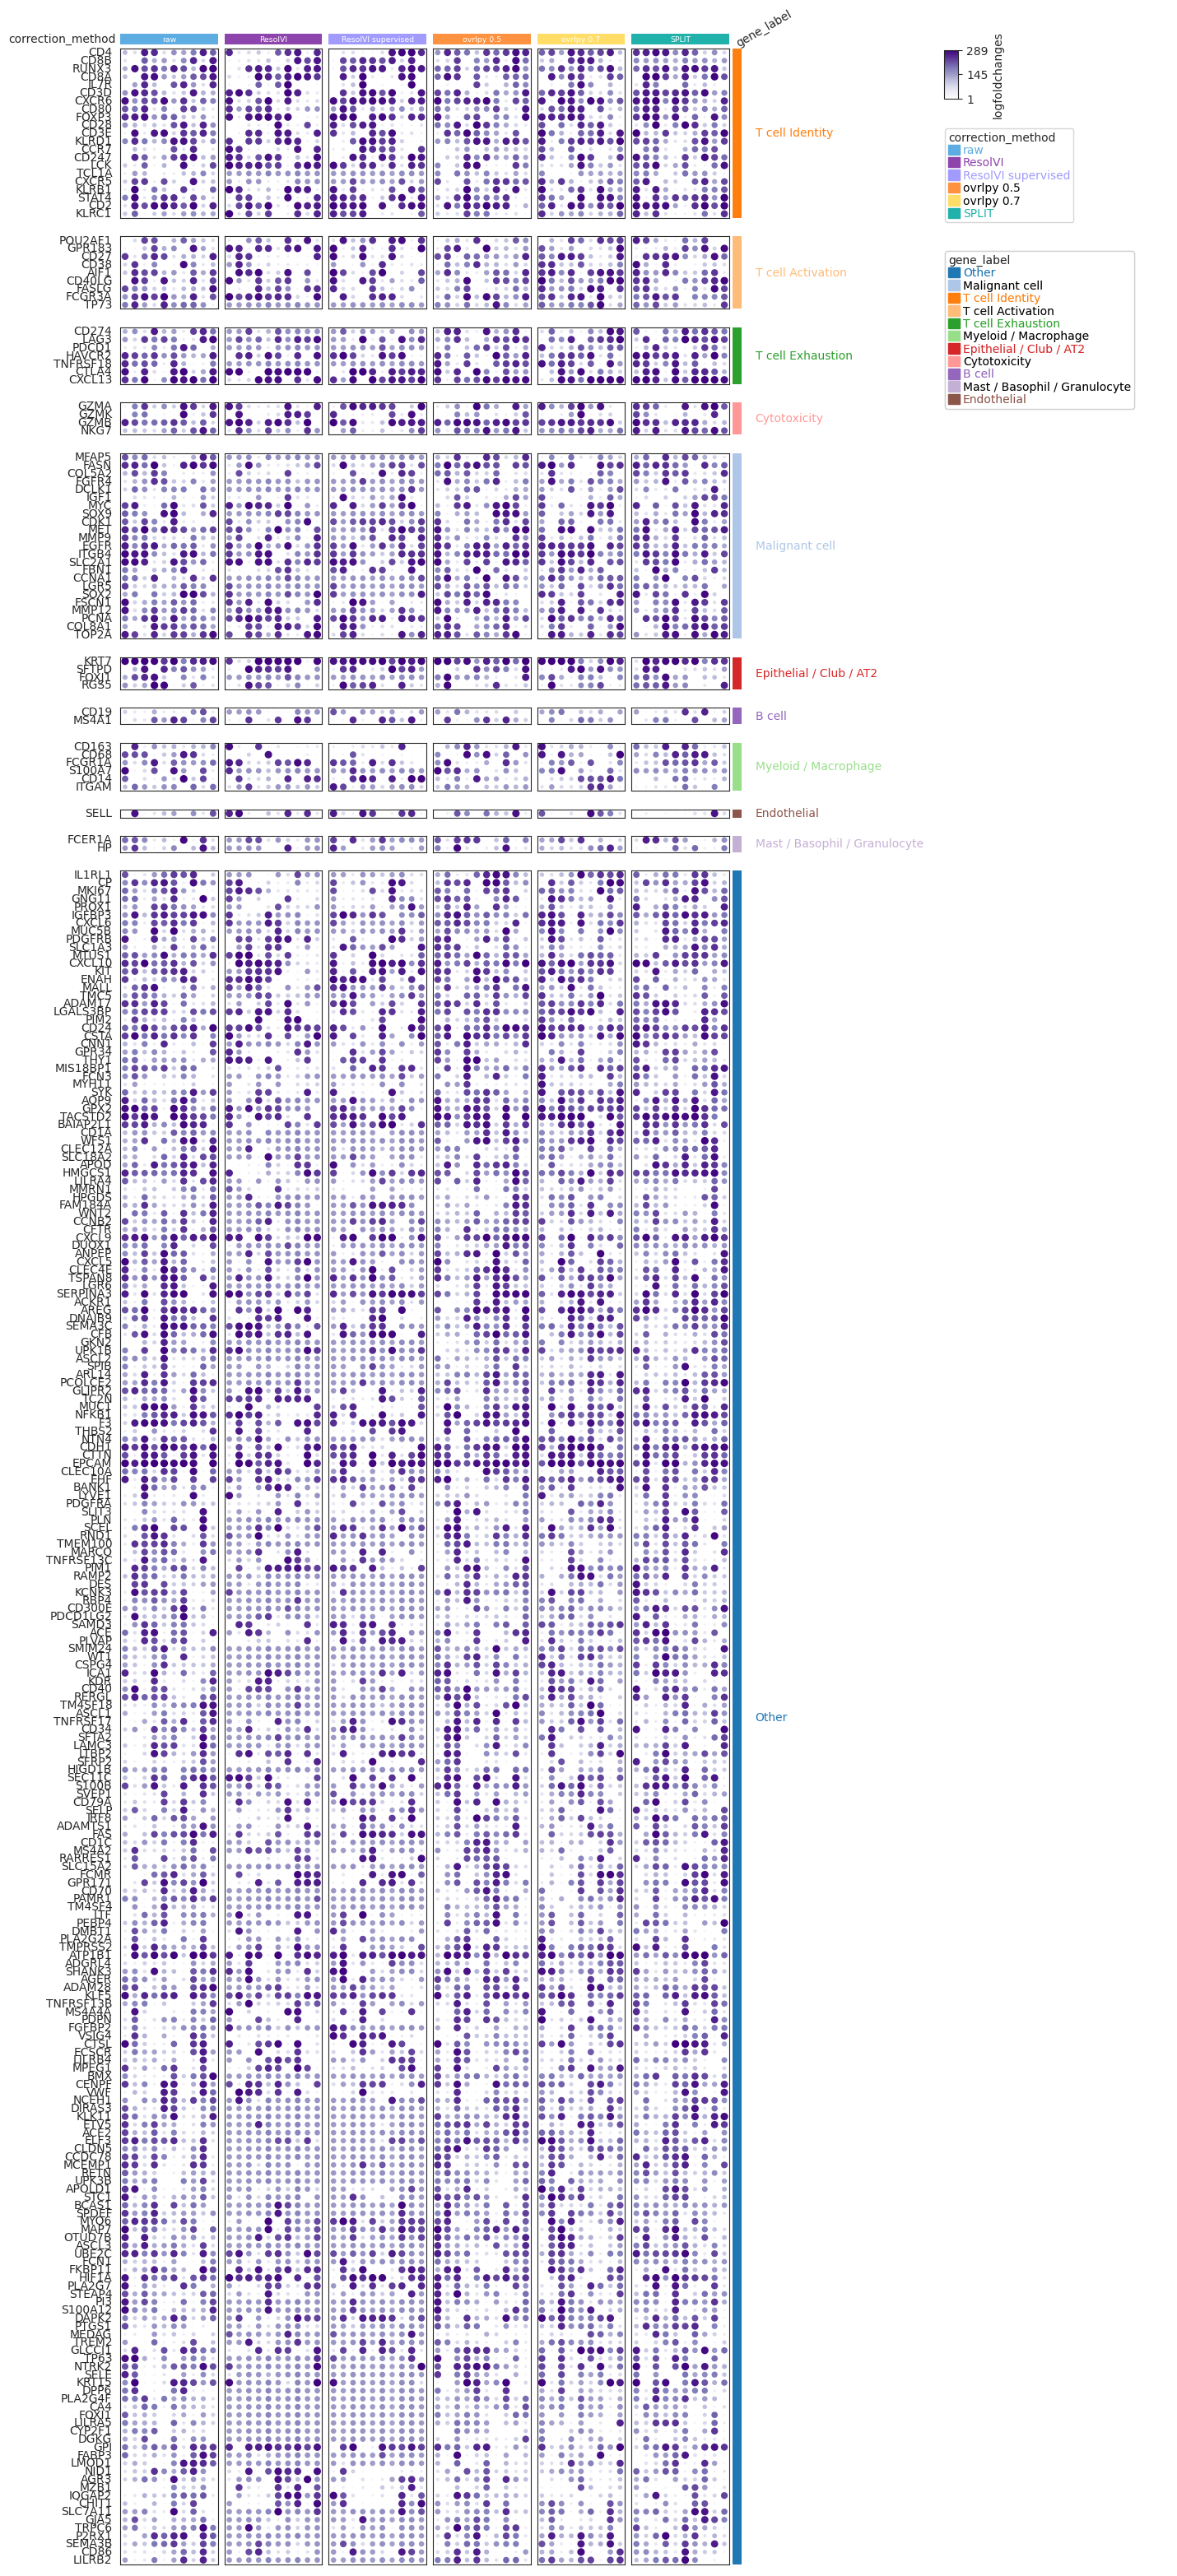

In [25]:
### params
df_ctj_marker_genes = _utils.get_df_ctj_marker_genes(dfs['df_ctj_marker_genes'],correction_methods)
cti = 'T cell'
ctj = 'malignant cell'
lung_genes_only = True
top_n = None
agg_func='median'
rank_metric='logfoldchanges'
rank_metric_pvals='pvals_adj'
rank_metric_logreg='importances'

list_ref_panel = ['lung','5k']
list_ref_segmentation = ['5µm','ProSeg']

Path('../../scratch/heatmaps/').mkdir(parents=True, exist_ok=True)
for ref_panel, ref_segmentation in itertools.product(list_ref_panel,list_ref_segmentation):

    if ref_panel == '5k' and ref_segmentation == '5µm':
        ref_segmentation = 'MM'

    #### extract data into df
    df = _utils.get_df_importances_cti_ctj(dfs['df_importances_logreg'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric_logreg)

    id_vars = df.columns[:8].tolist()
    value_vars = df.columns[8:].tolist()

    df_norm = df.copy()
    if ref_panel == '5k' and lung_genes_only:
        lung_panel_genes = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
        value_vars = [g for g in lung_panel_genes if g in df_norm.columns]
        df_norm = df_norm[id_vars+value_vars]

    # optionally normalize values
    df_norm[value_vars] =  df_norm[value_vars].replace(np.nan,0.)
    df_norm[value_vars] =  df_norm[value_vars].rank(ascending=True,axis=1)

    ### get median top n genes for each unique correction/segmentation/condition/panel
    if top_n is not None:
        id_vars_rank = ['correction_method', 'segmentation', 'condition', 'panel']

        df_top_genes = (
            df_norm.groupby(list(id_vars_rank))
            .apply(lambda g: get_top_n_genes(g, n=top_n, value_vars=value_vars,agg_func=agg_func,ascending=True))
            .reset_index()
        )
        df_top_genes.columns = id_vars_rank + ['top_genes']
        value_vars = list(set().union(*df_top_genes['top_genes']))
        df_norm = df_norm[id_vars+value_vars]

    ### define plot df
    df_plot = df_norm.melt(id_vars=id_vars,     
                            value_vars=value_vars,  
                            var_name='gene',                 
                            value_name=rank_metric)


    df_plot['ID'] = df_plot[id_vars].astype(str).agg('-'.join, axis=1)
    df_plot = df_plot.query(f"segmentation == '{ref_segmentation}'")
    df_plot['gene_label'] = df_plot['gene'].map(gene_labels_reverse)
    df_plot['gene_label'] = df_plot['gene_label'].fillna('Other')

    ### palettes
    unique_labels = [c for c in hue_correction_order if c in np.unique(df_plot[hue_correction].dropna())]
    unique_labels = unique_labels + [c for c in np.unique(df_plot[hue_correction].dropna()) if c not in unique_labels]
    palette = {u: count_correction_palette[u] for u in unique_labels}


    ### heatmap row/col labels
    df_col=df_plot[['segmentation','correction_method','panel','ID']].drop_duplicates()#.to_frame()
    df_col.set_index('ID',inplace=True)

    df_row=df_plot[['gene','gene_label']].drop_duplicates()
    df_row.set_index('gene',inplace=True)

    row_ha = HeatmapAnnotation(
                            gene_label=anno_simple(df_row['gene_label'],cmap='tab20',add_text=False,legend=True),
                            label=anno_label(df_row['gene_label'],cmap='tab20', merge=True,rotation=0,arrowprops = dict(visible=False)),
                            label_side='top',label_kws={'rotation':30,'horizontalalignment':'left'},
                            axis=0,verbose=0)


    col_ha = HeatmapAnnotation(
        correction_method=anno_simple(df_col['correction_method'], colors=count_correction_palette.to_dict(),legend=True,add_text=True),
        # panel=anno_simple(df_col['panel'], cmap='Dark2',legend=False,add_text=True),
        # segmentation=anno_simple(df_col['segmentation'], cmap='Set1',legend=False,add_text=True),
        verbose=0,label_side='left')


    ### heatmap 
    plt.figure(figsize=(10, 35))
    cm = DotClustermapPlotter(
        data=df_plot, 
        x='ID',y='gene',value=rank_metric,c=rank_metric,
        s=None,
        row_cluster=True,col_cluster=False,
        #hue='EnrichType', 
        #cmap={'Enrich':'RdYlGn_r','Depletion':'coolwarm_r'},
        #colors={'Enrich':'red','Depletion':'blue'},
        #marker={'Enrich':'^','Depletion':'v'},
        top_annotation=col_ha,
        right_annotation=row_ha,
        col_split=df_col['correction_method'],
        col_split_order=hue_correction_order,
        row_split=df_row['gene_label'], 
        row_split_order=[k for k in gene_labels.keys() if k in df_row['gene_label'].unique()],

        cmap='Purples',#center=0,
        col_split_gap=2,row_split_gap=5,
        show_rownames=True,show_colnames=False,row_dendrogram=False,
        verbose=1,legend_gap=10,grid=None,linewidths=.01,spines=True,
        # vmin=-0.04,vmax=0.04,
        ) #if the size of dot in legend is too large, use alpha to control, for example: alpha=0.8

    # plt.savefig(f"../../scratch/heatmaps/heatmap_{ref_panel=}_{ref_segmentation=}_{scale=}_{show_pvals=}.pdf",bbox_inches='tight',dpi=300)
    plt.show()

    break

# Heatmap GSEA

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index("names").loc[:, rank_metric]
  2%|▏         | 16/647 [00:00<00:17, 36.70it/s]2025-06-03 15:16:52,060 [WARNING] Duplicated values found in preranked stats: 3.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  3%|▎         | 20/647 [00:00<00:17, 36.49it/s]2025-06-03 15:16:52,171 [WARNING] Duplicated values found in preranked stats: 11.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  4%|▎         | 24/647 [00:00<00:17, 

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 26.160168350534498
Plotting legends..
Estimated legend width: 39.68888888888889 mm
Incresing ncol


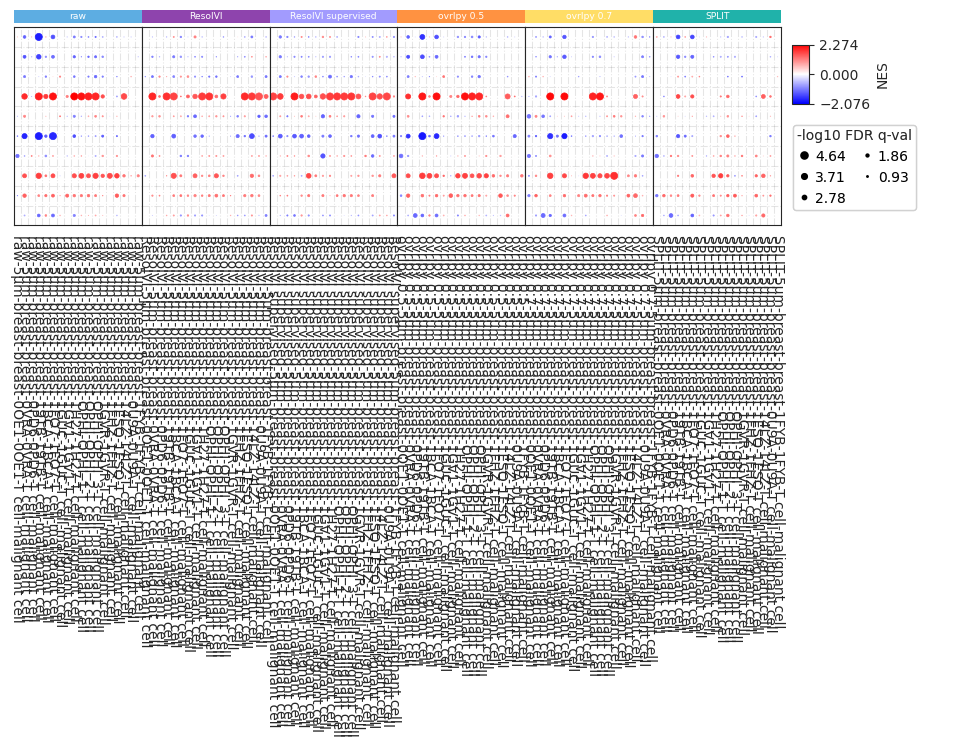

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index("names").loc[:, rank_metric]
  2%|▏         | 16/647 [00:00<00:16, 37.40it/s]2025-06-03 15:17:14,285 [WARNING] Duplicated values found in preranked stats: 3.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  3%|▎         | 20/647 [00:00<00:16, 37.29it/s]2025-06-03 15:17:14,393 [WARNING] Duplicated values found in preranked stats: 11.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  4%|▎         | 24/647 [00:00<00:16, 

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 26.160168350534498
Plotting legends..
Estimated legend width: 39.68888888888889 mm
Incresing ncol


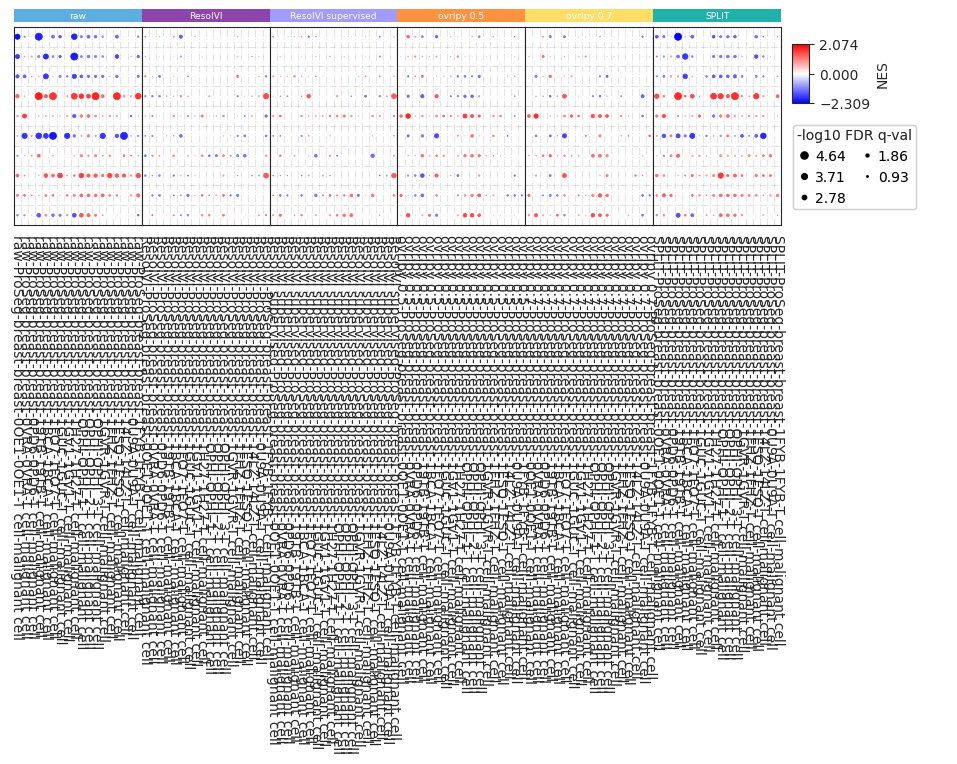

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index("names").loc[:, rank_metric]
  3%|▎         | 12/353 [00:00<00:09, 37.47it/s]2025-06-03 15:17:36,228 [WARNING] Duplicated values found in preranked stats: 2.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  5%|▍         | 16/353 [00:00<00:09, 37.34it/s]2025-06-03 15:17:36,415 [WARNING] Duplicated values found in preranked stats: 0.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  6%|▌         | 20/353 [00:00<00:08, 3

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 87.65647906941521
Plotting legends..
Estimated legend width: 39.68888888888889 mm
Incresing ncol


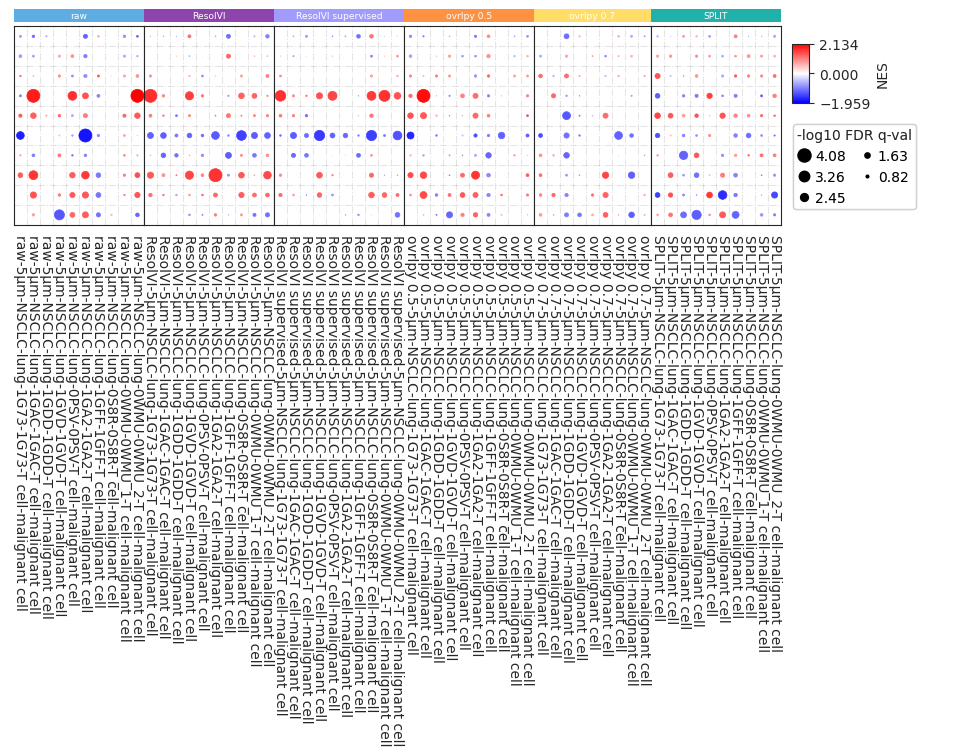

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index("names").loc[:, rank_metric]
  3%|▎         | 12/353 [00:00<00:09, 36.39it/s]2025-06-03 15:17:48,748 [WARNING] Duplicated values found in preranked stats: 2.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  5%|▍         | 16/353 [00:00<00:09, 36.93it/s]2025-06-03 15:17:48,932 [WARNING] Duplicated values found in preranked stats: 0.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  6%|▌         | 20/353 [00:00<00:08, 3

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 84.75894545573175
Plotting legends..
Estimated legend width: 39.68888888888889 mm
Incresing ncol


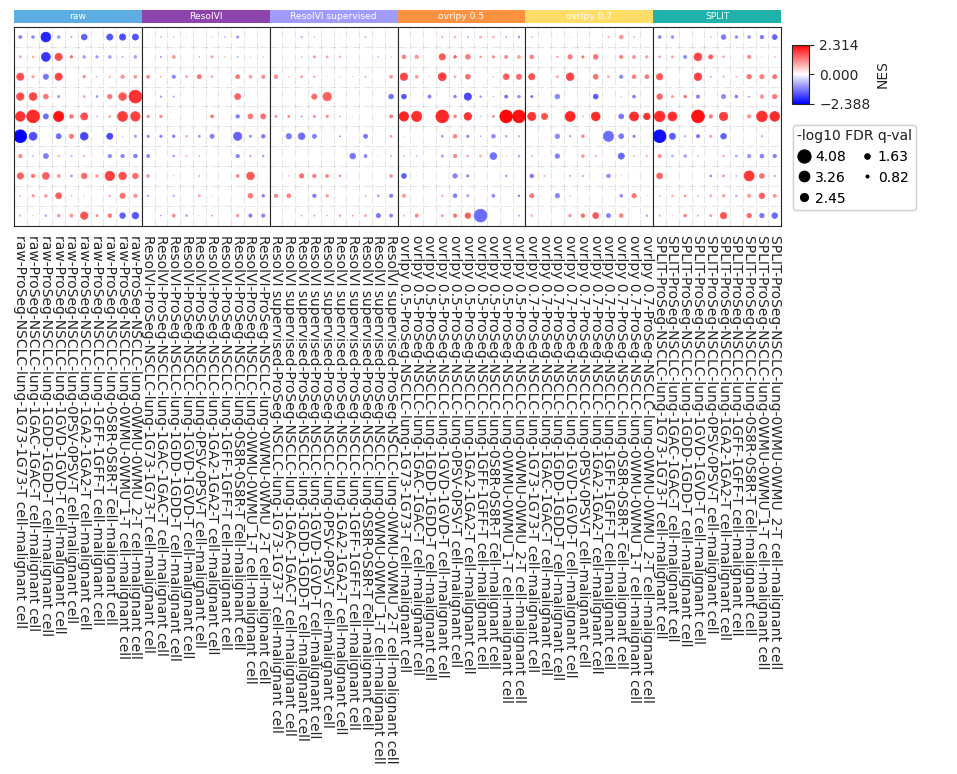

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:669: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (cti, ctj) in v.index:
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/workflow/notebooks/xenium/../../../workflow/scripts/_utils.py:670: PerformanceWarning: indexing past lexsort depth may impact performance.
  df[(correction_method, *k, cti, ctj)] = v.loc[(cti, ctj)].set_index("names").loc[:, rank_metric]
  0%|          | 0/173 [00:00<?, ?it/s]2025-06-03 15:18:02,079 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  2%|▏         | 3/173 [00:00<00:39,  4.27it/s]2025-06-03 15:18:02,770 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  3%|▎         | 6/173 [00:01<00:38,  4.33it/s]20

KeyboardInterrupt: 

In [ ]:
### params
cti = 'T cell'
ctj = 'malignant cell'
lung_genes_only = False
show_samples = False
agg_func='median'
rank_metric='logfoldchanges'
rank_metric_pvals='FDR q-val'
rank_metric_gsea = 'NES'

list_ref_panel = ['breast','lung','5k']
list_ref_segmentation = ['5µm','ProSeg']
list_gene_sets = [
    # 'KEGG_2021_Human',
    # 'Reactome_2022',
    # 'MSigDB_Hallmark_2020',
    # 'Immunologic_Signatures',
    'custom',
    # '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/markers/c7.immunesigdb.v2024.1.Hs.symbols.gmt'
]

keep_annotations = [
    'T cell', 
    'canonical T cell marker',
    'regulatory T cell',
    'exhausted T cell',
    'cytotoxic T cell',
    'immune response',
    'proliferation',
    'malignant cell',
    'fibroblast', 
    'epithelial cell'
    ]
negative_markers = ['CD28']


Path(cfg['figures_dir']+'heatmap_diffexpr_gsea').mkdir(parents=True, exist_ok=True)
for ref_panel, ref_segmentation, gene_sets_to_use in itertools.product(list_ref_panel, list_ref_segmentation, list_gene_sets):

    if ref_panel == '5k' and ref_segmentation == '5µm':
        ref_segmentation = 'MM'

    if ref_panel in ['lung','5k']:
        gene_labels = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata_DB.csv',encoding='latin1').groupby('Annotation_DB')['Gene'].agg(list)
    elif ref_panel == 'breast':
        gene_labels = pd.read_csv(cfg['markers_dir']+'Xenium_hBreast_v1_metadata_DB.csv',encoding='latin1').groupby('Annotation_DB')['Genes'].agg(list)
    gene_labels = {k:gene_labels[k] for k in keep_annotations}
    # gene_labels = gene_labels[gene_labels.map(lambda x: len(x))>2].to_dict()

    #### extract data into df
    df_diffexpr = _utils.get_df_diffexpr_cti_ctj(dfs_diffexpr['df_diffexpr'], cti, ctj, ref_panel, correction_methods, rank_metric=rank_metric)
    negative_markers_found = [g for g in negative_markers if g in df_diffexpr.columns]
    df_diffexpr[negative_markers_found] = df_diffexpr[negative_markers_found].mul(-1)

    id_vars = df_diffexpr.columns[:8].tolist()
    value_vars = df_diffexpr.columns[8:].tolist()

    df_diffexpr_norm = df_diffexpr.copy()
    # df_norm = df.copy()
    if ref_panel == '5k' and lung_genes_only:
        lung_panel_genes = pd.read_csv(cfg['markers_dir']+'Xenium_hLung_v1_metadata.csv')['Gene'].tolist()
        value_vars = [g for g in lung_panel_genes if g in df_diffexpr_norm.columns]
        df_diffexpr_norm = df_diffexpr_norm[id_vars+value_vars]

    ### define plot df
    if gene_sets_to_use == 'custom': 
        gene_sets = gene_labels
        figsize = (10,2.5)
        min_size = 0
    else:
        gene_sets = gene_sets_to_use
        figsize = (10,20)
        min_size = 15

    df_plot = get_df_gsea(df_diffexpr,gene_sets,id_vars,min_size=min_size)

    df_plot[rank_metric_gsea] = df_plot[rank_metric_gsea].astype(float)
    df_plot[rank_metric_pvals] = df_plot[rank_metric_pvals].astype(float)

    # clip 0 pvalues to minimum * 0.1 (to still distinguish them) 
    rank_metric_pvals_log = '-log10 '+rank_metric_pvals
    df_plot[rank_metric_pvals] = df_plot[rank_metric_pvals].replace(0.,df_plot.loc[df_plot[rank_metric_pvals]>0.,rank_metric_pvals].min()*.1)
    df_plot[rank_metric_pvals_log] = -np.log10(df_plot[rank_metric_pvals])

    df_plot['ID'] = df_plot[id_vars].astype(str).agg('-'.join, axis=1)
    df_plot = df_plot.query(f"segmentation == '{ref_segmentation}'")

    ### palettes
    unique_labels = [c for c in hue_correction_order if c in np.unique(df_plot[hue_correction].dropna())]
    unique_labels = unique_labels + [c for c in np.unique(df_plot[hue_correction].dropna()) if c not in unique_labels]
    palette = {u: count_correction_palette[u] for u in unique_labels}

    ### heatmap row/col labels
    df_col=df_plot[['segmentation','correction_method','panel','sample','ID']].drop_duplicates()#.to_frame()
    df_col.set_index('ID',inplace=True)
    df_col['correction_method'] = pd.Categorical(df_col['correction_method'], categories=hue_correction_order, ordered=True)
    df_col['sample'] = pd.Categorical(df_col['sample'], categories=sample_palette.index, ordered=True)
    df_col.sort_values(['correction_method','sample'],inplace=True)

    col_dict = {'':anno_simple(df_col['correction_method'], colors=count_correction_palette.to_dict(),legend=False,add_text=True),
                }
    if show_samples:
        col_dict[' '] = anno_simple(df_col['sample'], colors={k:v for k,v in sample_palette.items() if k in df_col['sample'].values},legend=True,add_text=False)
    col_ha = HeatmapAnnotation(**col_dict,verbose=0,label_side='left')


    figsize = (10,2.5)
    plt.figure(figsize=figsize)
    cm = DotClustermapPlotter(
        data=df_plot, 
        x='ID',y='Term',value=rank_metric_gsea,c=rank_metric_gsea,
        # x_order=df_col.index,
        s=rank_metric_pvals_log,
        row_cluster=False,col_cluster=False,
        top_annotation=col_ha,
        col_split=df_col['correction_method'],
        col_split_order=[h for h in hue_correction_order if h in df_col['correction_method'].unique()],
        # row_split=False,
        # col_split=df_col.index,
        # col_split_order=df_col.index,
        cmap='bwr',center=0,
        col_split_gap=0,
        show_rownames=False,show_colnames=True,
        row_dendrogram=False,col_dendrogram=False,
        verbose=1,legend_gap=5,linewidths=.5,spines=True,
        # xticklabels_kws={'text':df_col['sample']},
        # vmin = np.percentile(df_plot[rank_metric_gsea],5),
        # vmax = np.percentile(df_plot[rank_metric_gsea],95),
    )
    # cm.data2d.columns =  [s.split('-')[5] for s in cm.data2d.columns ]
    # cm.plot()
    plt.savefig(cfg['figures_dir']+f"heatmap_diffexpr_gsea/heatmap_{ref_panel=}_{ref_segmentation=}.png",bbox_inches='tight',dpi=300)
    plt.close()